In [2]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os 
import glob
import clip
from PIL import Image
import chromadb

In [3]:
def mask_to_bbox(mask, img_shape=None):
    # Get the indices of non-zero pixels in the mask (where the object is present)
    y_non_zero, x_non_zero = np.where(mask == 1)  # Get y, x coordinates of non-zero pixels

    if len(x_non_zero) == 0 or len(y_non_zero) == 0:
        # No object found in the mask
        return None

    # Get the bounding box coordinates and ensure they are integers
    x1 = int(np.min(x_non_zero))  # Minimum x-coordinate
    y1 = int(np.min(y_non_zero))  # Minimum y-coordinate
    x2 = int(np.max(x_non_zero))  # Maximum x-coordinate
    y2 = int(np.max(y_non_zero))  # Maximum y-coordinate

    # Ensure that the bounding box is within the image bounds
    if img_shape:
        x2 = min(x2, img_shape[1])
        y2 = min(y2, img_shape[0])

    # Ensure the bounding box has a positive width and height
    if x2 > x1 and y2 > y1:
        return x1, y1, x2, y2
    else:
        # Return None if the bounding box is invalid (e.g., width or height is 0)
        return None


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

def embed_image(img,model,preprocess):
    preprocessed = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
    torch.cuda.empty_cache()
    with torch.no_grad():
        embedding = model.encode_image(preprocessed).cpu().numpy().flatten()
    return embedding

In [8]:
base_path = 'data_from_runs/data_1743688590_329291105///'

# Get all image, mask, and object files
image_files = glob.glob(os.path.join(base_path, '**', 'rgb_image.png'), recursive=True)
mask_files = glob.glob(os.path.join(base_path, '**', 'mask.png'), recursive=True)
all_objects = glob.glob(os.path.join(base_path, '**', '*.pcd'), recursive=True)
unique_objects = []
for obj in all_objects:
    try:
        obj_label = obj.split("/")[-1].split(".")[0].split("_")[-1]
        obj_label_int = int(obj_label)
        unique_objects.append(obj_label_int)
    except ValueError:
        pass
unique_objects = list(set(unique_objects))


#instantiate chromadb client and create collection
collection_name = "object_embeddings"
chroma_client = chromadb.PersistentClient(path="./vector_store/")
for collection in chroma_client.list_collections():
    if collection.name == collection_name:
        chroma_client.delete_collection(collection.name)
collection = chroma_client.create_collection(
    name=collection_name,
    metadata={"hnsw:space": "cosine"},
)

for obj_label in unique_objects:
    obj_embeddings = []
    valid_image_path = None
    valid_mask_path = None
    valid_bbox = None
    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        obj_mask = np.where(mask == int(obj_label), 1, 0)
        bbox = mask_to_bbox(obj_mask)
        if bbox is not None:
            x1, y1, x2, y2 = bbox
            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 0 or crop.shape[1] < 0:
                continue
            valid_image_path = img_path
            valid_mask_path = mask_path
            valid_bbox = bbox
            embedding = embed_image(crop,model,preprocess)
            obj_embeddings.append(embedding)
    object_general_embedding = np.mean(obj_embeddings, axis=0, keepdims=False)
    collection.add(
            documents=[str(obj_label)],
            embeddings=[object_general_embedding],
            metadatas=[
                {
                    "img_path": valid_image_path,
                    "mask_path": valid_mask_path,
                    "object_label": obj_label,
                    "bbox": str(valid_bbox),
                }
            ],
            ids=[str(obj_label)]
        )
    print(f"Created document for object: {obj_label}")
            


Created document for object: 1
Created document for object: 2
Created document for object: 3
Created document for object: 4
Created document for object: 5
Created document for object: 6
Created document for object: 7
Created document for object: 8
Created document for object: 9
Created document for object: 10
Created document for object: 11
Created document for object: 12
Created document for object: 13
Created document for object: 14
Created document for object: 15
Created document for object: 16
Created document for object: 17
Created document for object: 18
Created document for object: 19
Created document for object: 20
Created document for object: 21
Created document for object: 22
Created document for object: 23
Created document for object: 24
Created document for object: 25
Created document for object: 26
Created document for object: 27
Created document for object: 28
Created document for object: 29
Created document for object: 30
Created document for object: 31
Created document 

In [5]:
def embed_text(text: str, model):
    """
    Encode a text string into a vector using CLIP.

    Parameters
    ----------
    text : str
        The text string to encode.
    model : torch.nn.Module
        The CLIP model to use for encoding.

    Returns
    -------
    text_features : numpy.ndarray
        The encoded vector.
    """
    text = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text).cpu().numpy().flatten()
    return text_features

def query_vectorstore(query: str, collection, threshold: float = 0.25):
    """
    Query a vector store collection with a text string to find the closest matching items.

    Parameters
    ----------
    query : str
        The text string to query the vector store with.
    collection : chromadb.Collection
        The collection to query against.
    threshold : float
        The minimum similarity score (0 to 1) to consider a match valid. Higher is more similar.

    Returns
    -------
    dict or None
        Metadata of the closest matching item if similarity exceeds threshold, else None.
    """
    text_features = embed_text(query, model)
    results = collection.query(
        query_embeddings=text_features,
        n_results=3
    )
    similarity= 1 - results["distances"][0][0]
    if similarity < threshold:
        print(f"No good matches found (closest similarity: {closest_similarity:.2f})")
        return None
    return {
        "cosine_similarity": similarity,
        "object_label": results["metadatas"][0][0]["object_label"],
        "img_path": results["metadatas"][0][0]["img_path"],
        "mask_path": results["metadatas"][0][0]["mask_path"],
        "bbox": results["metadatas"][0][0]["bbox"],
    }

def find_match(query: str, collection):
    results = query_vectorstore(query, collection)
    if results is not None:
        img = cv2.imread(results["img_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        object_label = results["object_label"]
        mask_path = results["mask_path"]

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask == object_label, 255, 0).astype(np.uint8)
        segmented_image = cv2.bitwise_and(img, img, mask=mask)
        x1,y1,x2,y2 = eval(results["bbox"])
        cropped_patch = img[y1:y2, x1:x2]
        fig,axs = plt.subplots(1,2)
        axs[0].imshow(cropped_patch)
        axs[1].imshow(segmented_image)
        plt.show()
        print(results)
    return

In [7]:
chroma_client = chromadb.PersistentClient(path="./vector_store/")
collection = chroma_client.get_collection("object_embeddings")

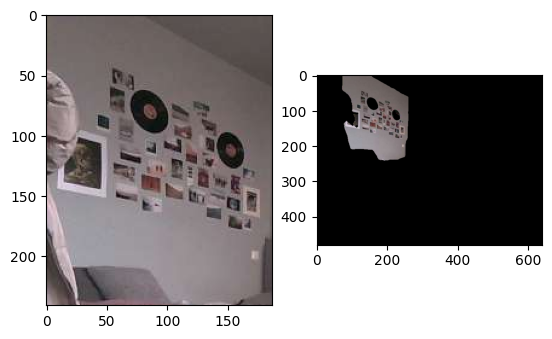

{'cosine_similarity': 0.28337401151657104, 'object_label': 58, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(71, 0, 258, 241)'}


In [8]:
find_match("vinyl", collection)

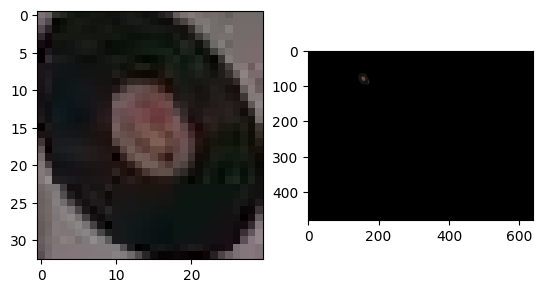

{'cosine_similarity': 0.2745303511619568, 'object_label': 30, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(142, 65, 172, 98)'}


In [9]:
find_match("black vinyl lp", collection)

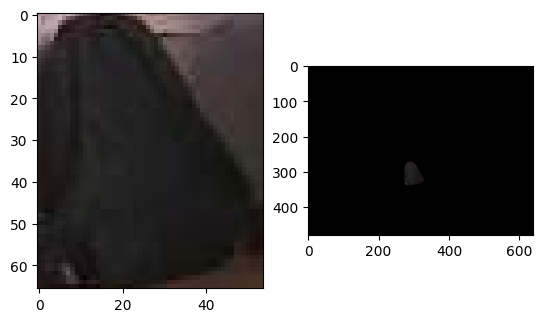

{'cosine_similarity': 0.25074875354766846, 'object_label': 34, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(273, 273, 327, 339)'}


In [10]:
find_match("jacket", collection)

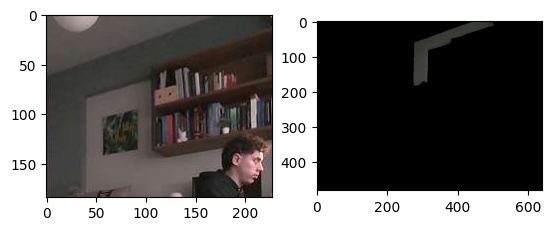

{'cosine_similarity': 0.25643718242645264, 'object_label': 38, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(273, 0, 500, 184)'}


In [11]:
find_match("ceiling", collection)

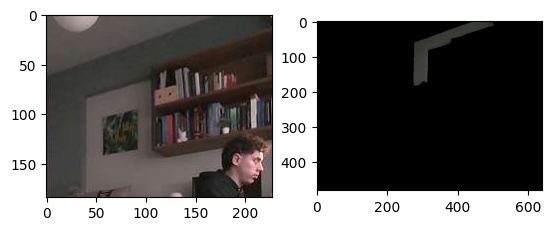

{'cosine_similarity': 0.26888948678970337, 'object_label': 38, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(273, 0, 500, 184)'}


In [12]:
find_match("bookcase", collection)

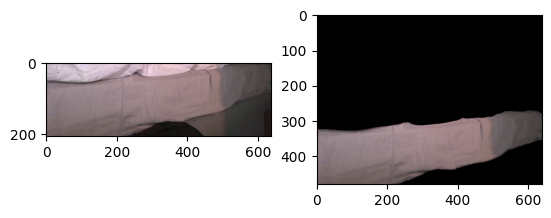

{'cosine_similarity': 0.26478493213653564, 'object_label': 94, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688635, 197171688)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688635, 197171688)/mask.png', 'bbox': '(0, 272, 639, 479)'}


In [13]:
find_match("bed", collection)

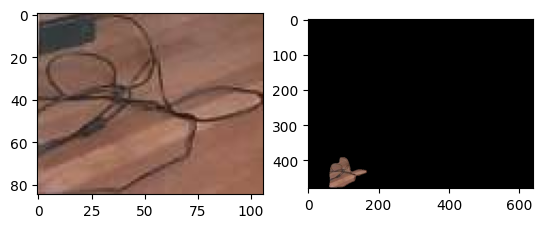

{'cosine_similarity': 0.262134850025177, 'object_label': 57, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(60, 393, 166, 478)'}


In [14]:
find_match("cables", collection)

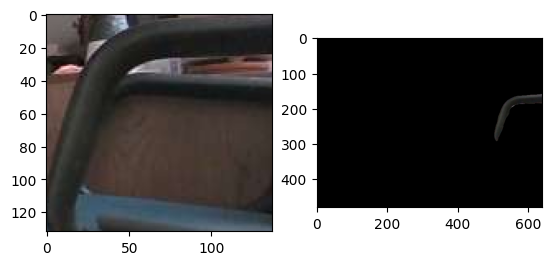

{'cosine_similarity': 0.26705247163772583, 'object_label': 35, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(502, 161, 639, 293)'}


In [15]:
find_match("chair", collection)

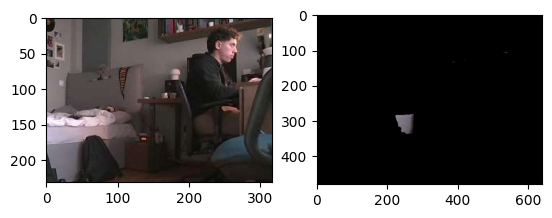

{'cosine_similarity': 0.2573249340057373, 'object_label': 68, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/mask.png', 'bbox': '(222, 107, 539, 338)'}


In [16]:
find_match("table", collection)

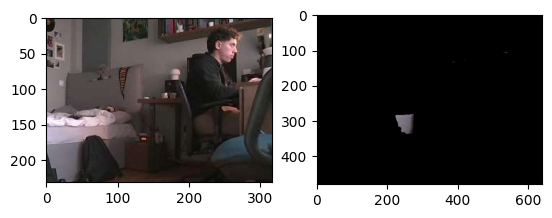

{'cosine_similarity': 0.2658360004425049, 'object_label': 68, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/mask.png', 'bbox': '(222, 107, 539, 338)'}


In [17]:
find_match("chair with a person sitting on top", collection)

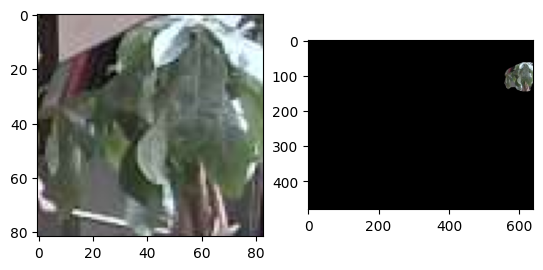

{'cosine_similarity': 0.26544106006622314, 'object_label': 56, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688595, 34347295)/mask.png', 'bbox': '(556, 65, 639, 147)'}


In [18]:
find_match("plant", collection)

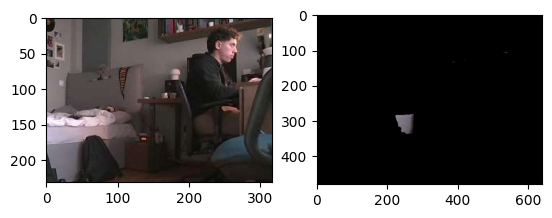

{'cosine_similarity': 0.25043272972106934, 'object_label': 68, 'img_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/rgb_image.png', 'mask_path': 'data_from_runs/data_1743688590_329291105/(1743688602, 952101945)/mask.png', 'bbox': '(222, 107, 539, 338)'}


In [19]:
find_match("person", collection)

In [20]:
collection.count()

102